Pairwise tests (cartesian product):



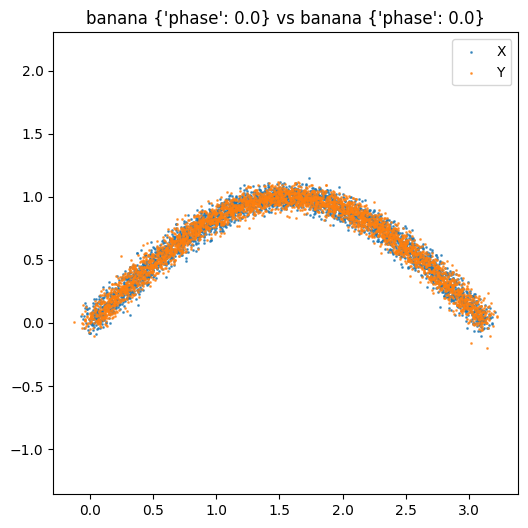

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


(banana, {'phase': 0.0}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.006449 (time: 0.00s)
   Gromov-Wasserstein:      0.016148128691703872 (time: 56.44s)
   Standard OT:             0.12079804883157154 (time: 1.81s)
   Procrustes OT:           0.12075557252145576 (time: 4.56s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.01413, 6.931s
      k= 10, t= 1: 0.04337, 6.820s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.006591, 0.058s
      n_proj=1000: 0.006489, 0.346s
      n_proj=10000: 0.006481, 2.568s



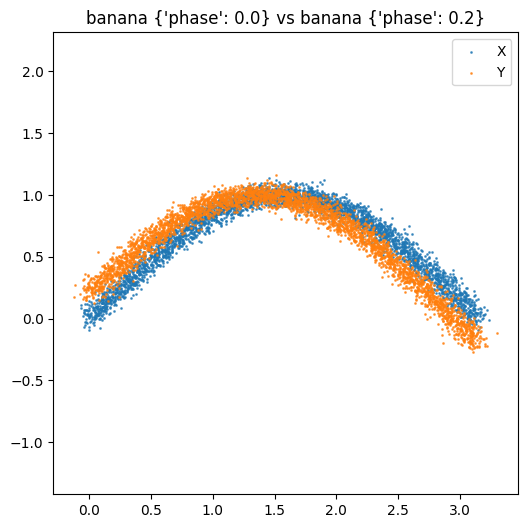

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
from sklearn.decomposition import PCA
from scipy.linalg import orthogonal_procrustes
from scipy.sparse.linalg import eigsh
from sklearn import datasets
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
import os


try:
    import ot  # POT: Python Optimal Transport
    has_pot = True
except ImportError:
    print("python-ot (POT) not found, Gromov-Wasserstein/OT comparison disabled")
    has_pot = False

######################
# Embedding Functions #
######################

def pca_embedding(X, k=None):
    Xc = X - X.mean(axis=0)
    pca = PCA(n_components=k if k else X.shape[1])
    pca.fit(Xc)
    return pca.transform(Xc)  # returns n x k array, like diffusion_embedding

# think more about t and symmetric normalization
def diffusion_embedding(X, k=5, epsilon=None, t=1):
    Xc = X - X.mean(axis=0)
    n = Xc.shape[0]
    D_sq = cdist(Xc, Xc, 'sqeuclidean')
    if epsilon is None:
        epsilon = np.median(D_sq)
    K = np.exp(-D_sq / epsilon)
    d = np.sum(K, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))
    P_tilde = D_inv_sqrt @ K @ D_inv_sqrt

    # --- Choose eigensolver automatically ---
    # Full eigendecomposition if k >= n-1
    if k >= n - 1:
        vals, vecs = eigh(P_tilde)
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        # Remove the trivial eigenvector (usually the top one)
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]
    else:
        # Partial: only top k+1
        vals, vecs = eigsh(P_tilde, k=k+1, which='LM')
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]

    embedding_matrix = phis * (lambdas ** t)
    return embedding_matrix


###################################
# Sliced Wasserstein Assignment   #
###################################

def get_sorted_columns(A):
    # A: n x k array
    # Returns: list of length k, each is sorted 1D array of size n
    return [np.sort(A[:, i]) for i in range(A.shape[1])]

# write more general 1D Wasserstein distance
def compute_1d_wasserstein_sorted(u_sorted, v_sorted):
    # Both should be pre-sorted arrays
    return np.mean((u_sorted - v_sorted)**2) # square is built in

def assignment_sliced_wasserstein(X, Y, AX, BY):
    k = AX.shape[1]
    # Precompute and cache sorted columns
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            d_pos = compute_1d_wasserstein_sorted(AX_sorted[i], BY_sorted[j])
            d_neg = compute_1d_wasserstein_sorted(AX_sorted[i], -BY_sorted[j])
            C[i, j] = min(d_pos, d_neg) # square has been done already
    row_ind, col_ind = linear_sum_assignment(C)
    total_cost = C[row_ind, col_ind].sum()
    return np.sqrt(total_cost/k) # to hopefully be a pseudometric - regardless, matching units

##############################
# Baselines: GW and OT and ...#
##############################

def gromov_wasserstein(X, Y):
    if not has_pot:
        return np.nan
    C1 = cdist(X, X)  # pairwise distance matrix for X
    C2 = cdist(Y, Y)  # pairwise distance matrix for Y
    # we assume uniform distributions for both sets
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    # GW returns the cost directly (not the coupling)
    gw_cost = ot.gromov.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    return np.sqrt(gw_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent


def standard_ot(X, Y):
    if X.shape[1] != Y.shape[1]: # need to live in same dimensional space
        raise ValueError(f"OT: Feature dimension mismatch: {X.shape[1]} vs {Y.shape[1]}")
    # same deal as GW
    C = cdist(X, Y)
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    T = ot.emd(p, q, C, numItermax=10000000)
    ot_cost = (C * T).sum()
    return np.sqrt(ot_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent

def orthogonal_procrustes_matching(X, Y, max_iter=100, tol=1e-6, verbose=False):
    """
    Find the best orthogonal R (no scaling) and permutation π so that Xc ≈ (Yc @ R)[π].
    Returns the sum of squared distances under that R + π.
    """
    # 1) center both clouds
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    n, d = Xc.shape

    # 2) start with the identity matching
    π = np.arange(n)
    cost_prev = np.inf

    for it in range(max_iter):
        # ─── Step 1: find the orthogonal rotation R (no scale) that best aligns Yc[π] → Xc ───
        R, _ = orthogonal_procrustes(Yc[π], Xc)
        Yc_rot = Yc @ R   # *** drop any scale ***

        # ─── Step 2: re‐compute the one‐to‐one assignment under the new rotation ───
        C = cdist(Xc, Yc_rot, metric='sqeuclidean')
        row_ind, col_ind = linear_sum_assignment(C)
        cost = C[row_ind, col_ind].sum()

        if verbose:
            print(f"Iter {it}: cost = {cost:.8f}")

        # check convergence
        if abs(cost - cost_prev) < tol:
            break

        cost_prev = cost
        π = col_ind

    # ─── Final transform (pure rotation + centroid shift) ───
    R, _ = orthogonal_procrustes(Yc[π], Xc)
    Yc_aligned = Yc @ R
    # add back X’s centroid
    Y_aligned = Yc_aligned + X.mean(axis=0)

    return cost, (Y_aligned, R, π)


def procrustes_ot(X, Y):
    if X.shape != Y.shape:
        raise ValueError(f"Procrustes: Shape mismatch {X.shape} vs {Y.shape}")
    cost, (Y_aligned, R, pi) = orthogonal_procrustes_matching(X, Y)
    # Now you can compare X and Y_aligned, or run OT/GW/etc.
    # For vanilla OT cost:
    return standard_ot(X, Y_aligned)

def sliced_wasserstein(X, Y, n_proj=100, p=2, seed=None):
    """
    Standard Sliced Wasserstein (squared Wp, default W2):
      - Projects onto random unit vectors
      - Computes 1D Wasserstein between projections
      - Returns the mean distance across all projections (root if p=2)
    """
    if X.shape[1] != Y.shape[1]:
        raise ValueError(f"SW: Feature dimension mismatch: {X.shape[1]} vs {Y.shape[1]}")
    rng = np.random.default_rng(seed)
    n, d = X.shape
    m = Y.shape[0]
    dists = []
    for _ in range(n_proj):
        v = rng.normal(size=d)
        v /= np.linalg.norm(v)  # unit vector

        # Project onto v
        X_proj = np.dot(X, v)
        Y_proj = np.dot(Y, v)

        # Sort and compute 1D Wasserstein-p distance
        X_proj_sorted = np.sort(X_proj)
        Y_proj_sorted = np.sort(Y_proj)
        # Need equal sizes for empirical distributions: subsample or interpolate if needed
        n_used = min(len(X_proj_sorted), len(Y_proj_sorted))
        Xs = X_proj_sorted[:n_used]
        Ys = Y_proj_sorted[:n_used]
        dist = np.mean(np.abs(Xs - Ys) ** p)
        dists.append(dist)

    return np.mean(dists)**(1/p)




########################
# Synthetic Datasets   #
########################

def generate_dataset(kind, n=100, d=2, mean=None, cov=None, angle=None, phase=None):
    if kind == 'normal':
        m = mean if mean is not None else np.zeros(d)
        c = cov if cov is not None else np.eye(d)
        X = np.random.multivariate_normal(m, c, n)
        return X
    elif kind == 'banana':
        t = np.linspace(0, np.pi, n)
        phi = phase if phase is not None else 0.0
        X = np.vstack([t, np.sin(t + phi)]).T + 0.05 * np.random.randn(n, 2)
        return X
    elif kind == 'cylinder':
        theta = np.random.uniform(0, 2*np.pi, n)
        z = np.random.uniform(-1, 1, n)
        ang = angle if angle is not None else 0.0
        X = np.vstack([np.cos(theta + ang), np.sin(theta + ang), z]).T
        return X
    elif kind == 'swissroll':
        X, _ = datasets.make_swiss_roll(n)
        return X[:, :d]
    else:
        raise ValueError('Unknown dataset kind')

def plot_pair(X, Y, title=None, savepath=None):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], s=1, label='X', alpha=0.7)
    plt.scatter(Y[:,0], Y[:,1], s=1, label='Y', alpha=0.7)
    plt.axis('equal')
    plt.legend()
    if title:
        plt.title(title)
    if savepath:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

##########################################################
# Dataset parameterizations to try (expand as desired)   #
##########################################################

DATASET_PARAMS = {
    'banana': [
        dict(phase=0.0), 
        dict(phase=0.2),
        dict(phase=1.0),
    ],
    'cylinder': [
        dict(angle=0.0), 
        dict(angle=0.2),
        dict(angle=np.pi/2),
    ],
    'normal': [
        dict(mean=np.zeros(2)), 
        dict(mean=np.ones(2)), 
        dict(mean=np.array([2.0, -2.0])),
        dict(mean=np.zeros(2), cov=np.diag([1, 4])),
        dict(mean=np.zeros(2), cov=2*np.eye(2)),
        dict(mean=np.zeros(2), angle=np.pi/4),  # for rotation
    ],
    'swissroll': [
        dict(),  # no params
    ]
}

########################################
# Cartesian Product of Tests Framework #
########################################

def test_diffusion_grid(X, Y, k_values, t_values, distance_fn):
    results = {}
    for k in k_values:
        for t in t_values:
            try:
                t0 = time.time()
                AX = diffusion_embedding(X, k=k, t=t)
                BY = diffusion_embedding(Y, k=k, t=t)
                # Optionally rescale to match variance for fair distance comparison
                # This can be shown to just scale the distance by a constant factor scale^1 (scale^2 is sqrted), so it is monotonic and solely for fair comparison
                scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
                AX *= scale
                BY *= scale
                dist = distance_fn(X, Y, AX, BY)
                t1 = time.time()
                results[(k, t)] = (dist, t1 - t0)
            except Exception as e:
                results[(k, t)] = (str(e), None)  # capture any errors
    return results

def test_sliced_wasserstein_proj(X, Y, n_proj_values, seed=None):
    results = {}
    for n_proj in n_proj_values:
        try:
            t0 = time.time()
            dist = sliced_wasserstein(X, Y, n_proj=n_proj, p=2, seed=seed)
            t1 = time.time()
            results[n_proj] = (dist, t1 - t0)
        except Exception as e:
            results[n_proj] = (str(e), None)
    return results

def test_framework():
    dataset_types = list(DATASET_PARAMS.keys())
    configs = []
    for dtype in dataset_types:
        for params in DATASET_PARAMS[dtype]:
            configs.append((dtype, params))

    # Grid parameters
    k_values = [10]
    t_values = [0, 1]
    n_proj_values = [100, 1000, 10000]

    print("Pairwise tests (cartesian product):\n")
    for (dtype1, p1), (dtype2, p2) in itertools.product(configs, configs):
        n = 3500
        X = generate_dataset(dtype1, n=n, d=2, **p1)
        Y = generate_dataset(dtype2, n=n, d=2, **p2)
        plot_pair(X, Y, title=f'{dtype1} {p1} vs {dtype2} {p2}', savepath=None)
        k = min(X.shape[1], Y.shape[1])

        # PCA embedding baseline
        t0 = time.time()
        AX = pca_embedding(X, k)
        BY = pca_embedding(Y, k)
        # Scale PCA embeddings to match input variance - heuristic
        # This can be shown to just scale the distance by a constant factor scale^1 (scale^2 is sqrted), so it is monotonic and solely for fair comparison
        scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
        AX *= scale
        BY *= scale
        d_pca = assignment_sliced_wasserstein(X, Y, AX, BY)
        t1 = time.time()
        pca_time = t1 - t0

        # Diffusion embedding grid (k, t)
        diffusion_results = test_diffusion_grid(
            X, Y, k_values=k_values, t_values=t_values,
            distance_fn=assignment_sliced_wasserstein
        )

        # Sliced Wasserstein with varying n_proj (standard)
        sw_proj_results = test_sliced_wasserstein_proj(
            X, Y, n_proj_values=n_proj_values, seed=42
        )

        # GW, OT, Procrustes
        t0 = time.time()
        d_gw = gromov_wasserstein(X, Y)
        t1 = time.time()
        gw_time = t1 - t0

        try:
            t0 = time.time()
            d_ot = standard_ot(X, Y)
            t1 = time.time()
            ot_time = t1 - t0
        except ValueError as e:
            d_ot = str(e)
            ot_time = None

        try: 
            t0 = time.time()
            d_proc = procrustes_ot(X, Y)
            t1 = time.time()
            procrustes_time = t1 - t0
        except ValueError as e:
            d_proc = str(e)
            procrustes_time = None

        print(f'({dtype1}, {p1}) vs ({dtype2}, {p2})')
        print(f'   SlicedWasserstein-PCA:   {d_pca:.4g} (time: {pca_time:.2f}s)' if pca_time is not None else '   SlicedWasserstein-PCA:   Error')
        print(f'   Gromov-Wasserstein:      {d_gw} (time: {gw_time:.2f}s)' if gw_time is not None else '   Gromov-Wasserstein:      Error')
        print(f'   Standard OT:             {d_ot} (time: {ot_time:.2f}s)' if ot_time is not None else '   Standard OT:             Error')
        print(f'   Procrustes OT:           {d_proc} (time: {procrustes_time:.2f}s)' if procrustes_time is not None else '   Procrustes OT:           Error')
        print('   --- Diffusion grid (assignment SlicedWasserstein) ---')
        for (kk, tt), (dist, t_elapsed) in sorted(diffusion_results.items()):
            print(f'      k={kk:3d}, t={tt:2d}: {dist:.4g}, {t_elapsed:.3f}s' if t_elapsed is not None else f'      k={kk:3d}, t={tt:2d}: Error')
        print('   --- Standard Sliced Wasserstein by n_proj ---')
        for n_proj, (dist, t_elapsed) in sorted(sw_proj_results.items()):
            print(f'      n_proj={n_proj:4d}: {dist:.4g}, {t_elapsed:.3f}s' if t_elapsed is not None else f'      n_proj={n_proj:4d}: Error')
        print()

if __name__ == '__main__':
    test_framework()

In [9]:
def compute_distance_matrix(distance_fn, embedding_fn, k=2, out_path="distance_matrix.csv"):
    dataset_types = list(DATASET_PARAMS.keys())
    configs = []
    labels = []

    for dtype in dataset_types:
        for params in DATASET_PARAMS[dtype]:
            configs.append((dtype, params))
            labels.append(f"{dtype}_{str(params)}")

    n = 10000000
    dist_matrix = np.zeros((len(configs), len(configs)))

    for i, (dtype1, p1) in enumerate(configs):
        X = generate_dataset(dtype1, n=n, d=2, **p1)
        AX = embedding_fn(X, k)
        scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
        AX *= scale

        for j, (dtype2, p2) in enumerate(configs):
            if j < i:
                dist_matrix[i, j] = dist_matrix[j, i]
                continue

            Y = generate_dataset(dtype2, n=n, d=2, **p2)
            BY = embedding_fn(Y, k)
            scale = np.sqrt(np.trace(np.cov(Y.T)) / np.trace(np.cov(BY.T)))
            BY *= scale

            try:
                dist = distance_fn(X, Y, AX, BY)
            except Exception as e:
                print(f"Error between {labels[i]} and {labels[j]}: {e}")
                dist = np.nan

            dist_matrix[i, j] = dist

    df = pd.DataFrame(dist_matrix, index=labels, columns=labels)
    df.to_csv(out_path)
    print(f"Saved distance matrix to {os.path.abspath(out_path)}")

    return df

def check_triangle_inequality(df):
    D = df.values
    labels = df.index.tolist()
    n = len(D)

    violations = []
    max_violation = 0.0

    for i in range(n):
        for j in range(n):
            for k in range(n):
                if i == j or j == k or i == k:
                    continue
                lhs = D[i, k]
                rhs = D[i, j] + D[j, k]
                if not np.isnan(lhs) and not np.isnan(rhs) and lhs > rhs + 1e-8:
                    violation_amt = lhs - rhs
                    violations.append((labels[i], labels[j], labels[k], violation_amt))
                    max_violation = max(max_violation, violation_amt)

    print(f"\nChecked {len(violations)} triangle inequality violations.")
    if violations:
        print(f"Max violation: {max_violation:.6f}")
        print("Examples:")
        for a, b, c, v in sorted(violations, key=lambda x: -x[3])[:5]:
            print(f"  D({a}, {c}) > D({a}, {b}) + D({b}, {c}) by {v:.6f}")
    else:
        print("All triangles satisfied the triangle inequality.")

    return violations

def filter_2d_only_violations(violations):
    def is_2d(label):
        return not label.startswith("cylinder")

    pure_2d_violations = [
        (a, b, c, v) for (a, b, c, v) in violations
        if is_2d(a) and is_2d(b) and is_2d(c)
    ]

    print(f"\nTriangle inequality violations among only 2D datasets: {len(pure_2d_violations)}")
    if pure_2d_violations:
        max_violation = max(pure_2d_violations, key=lambda x: x[3])[3]
        print(f"Max 2D-only violation: {max_violation:.6f}")
        for a, b, c, v in sorted(pure_2d_violations, key=lambda x: -x[3])[:5]:
            print(f"  D({a}, {c}) > D({a}, {b}) + D({b}, {c}) by {v:.6f}")
    else:
        print("✅ No triangle inequality violations among 2D-only datasets.")

    return pure_2d_violations

if __name__ == '__main__':
    #df = compute_distance_matrix(
    #    distance_fn=assignment_sliced_wasserstein,
    #    embedding_fn=lambda X, k: diffusion_embedding(X, k=k, t=1),  # you can change t=1 to other values
    #    k=10000000000000,
    #    out_path="shape_distances_diffusion_t1.csv"
    #)
S
    #violations = check_triangle_inequality(df)
    #filter_2d_only_violations(violations)

    df = compute_distance_matrix(
        distance_fn=assignment_sliced_wasserstein,
        embedding_fn=pca_embedding,
        k=2,
        out_path="shape_distances_pca.csv"
    )

    violations = check_triangle_inequality(df)
    filter_2d_only_violations(violations)


Saved distance matrix to c:\Users\zakkh\PAIRSWEEP\shape_distances_pca.csv

Checked 20 triangle inequality violations.
Max violation: 0.001236
Examples:
  D(normal_{'mean': array([1., 1.])}, swissroll_{}) > D(normal_{'mean': array([1., 1.])}, normal_{'mean': array([ 2., -2.])}) + D(normal_{'mean': array([ 2., -2.])}, swissroll_{}) by 0.001236
  D(swissroll_{}, normal_{'mean': array([1., 1.])}) > D(swissroll_{}, normal_{'mean': array([ 2., -2.])}) + D(normal_{'mean': array([ 2., -2.])}, normal_{'mean': array([1., 1.])}) by 0.001236
  D(normal_{'mean': array([1., 1.])}, swissroll_{}) > D(normal_{'mean': array([1., 1.])}, normal_{'mean': array([0., 0.]), 'angle': 0.7853981633974483}) + D(normal_{'mean': array([0., 0.]), 'angle': 0.7853981633974483}, swissroll_{}) by 0.001081
  D(swissroll_{}, normal_{'mean': array([1., 1.])}) > D(swissroll_{}, normal_{'mean': array([0., 0.]), 'angle': 0.7853981633974483}) + D(normal_{'mean': array([0., 0.]), 'angle': 0.7853981633974483}, normal_{'mean': ar